# Evaluate Trichotomy

## Overview 

Notebook that provides code to evaluate trained diffusion models. Needs image generation model, privacy model, cxr-classification model. 

In [4]:
%run ../basesetup.ipynb 
# load basic functions such as generative model initializer, classification model, privacy mdoel
from PIL import Image

# Generate new images if necessary 

In [16]:
# generate new 
# %run ./02_gen_trich.ipynb
clf_model_path = "/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/results_chexnet_real/saved_models_cxr8/m-05122024-131940.pth.tar"


# Code to Load Chestxray classification Model 

In [17]:
image_x_1 = Image.open("/vol/ideadata/ed52egek/data/chestxray14/images/00007303_000.png").convert('RGB')  
image_x_2 = Image.open("/vol/ideadata/ed52egek/data/chestxray14/images/00007303_001.png").convert('RGB')  
image_y_1 = Image.open("/vol/ideadata/ed52egek/data/chestxray14/images/00007304_000.png").convert('RGB')  

clf_model = get_classification_model(clf_model_path)
pred, hidden = clf_model.lazy_foward(image_x_1)
print(hidden, pred)

/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_4013311/1464333085.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See h

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6191, 1.4581, 0.8807]],
       device='cuda:0') tensor([[9.5346e-01, 8.1594e-03, 5.3468e-03, 1.4601e-02, 5.3577e-04, 9.2468e-03,
         3.7475e-03, 7.7365e-03]], device='cuda:0')


# Code to load privacy model 


In [8]:
privnet = get_privacy_model()
privnet = privnet.to("cuda")
privnet.lazy_pred(image_x_1, image_x_2)


/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3019574/1870464355.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:

NameError: name 'image_x_1' is not defined

In [5]:
N=100
n_per_index = 1
filelist = "/vol/ideadata/ed52egek/pycharm/trichotomy/datasets/eight_cxr8_train.txt" 
real_files = []
for class_idx, class_name in enumerate(class_labels):
    dataset, indices = get_ds_and_indices(filelist=filelist, class_idx=class_idx, n_per_index=n_per_index, N=N)
    file_list = [dataset.file_list[idx] for idx in indices]
    for file in file_list: 
        real_files.append(
            {
                'full_path': file,
                'is_real': True,
                'model_name': "Real",
                'class_name': class_name,
                'real_image_name': "",
            }
        )



# TODO

### data now holds 3 real and 3 snth iamges for each class 
1. Check privacy using the sigmoid activation without threshold - Are there positive predictions ? Which one is more susceptible to privacy issues? 
2. Visualize clusters. Color code classes. see if clusters are better? 

In [6]:
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class ImageDatasetReal(Dataset):
    def __init__(self, root_dir, real_files, transform=None):
        """
        Args:
            root_dir (str): Root directory containing the image folders.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = real_files

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_info = self.image_list[idx]
        full_path = os.path.join(self.root_dir, image_info['full_path'])
        image = Image.open(full_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return {
            'image': image,
            'is_real': True,
            'model_name': image_info['model_name'],
            'class_name': image_info['class_name'],
            'full_path': full_path,
            'real_image_name': image_info['real_image_name']
        }

class SnthImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing the image folders.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = []
        self._load_images()

    def _load_images(self):
        # Traverse the directory and collect image information
        for model_name in os.listdir(self.root_dir):
            model_path = os.path.join(self.root_dir, model_name)
            if os.path.isdir(model_path):
                for class_name in os.listdir(model_path):
                    class_path = os.path.join(model_path, class_name)
                    if os.path.isdir(class_path):
                        images_path = os.path.join(class_path, 'images')
                        if os.path.isdir(images_path):
                            for image_name in os.listdir(images_path):
                                if image_name.endswith('.png'):
                                    # Extract real image name
                                    real_image_name = '_'.join(image_name.split('_')[:2]) + '.png'
                                    self.image_list.append({
                                        'model_name': model_name,
                                        'class_name': class_name,
                                        'real_image_name': real_image_name,
                                        'full_path': os.path.join(images_path, image_name)
                                    })

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_info = self.image_list[idx]
        image = Image.open(image_info['full_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return {
            'image': image,
            'is_real': False,
            'model_name': image_info['model_name'],
            'class_name': image_info['class_name'].replace("_", " "), # No_finding --> No Finding 
            'full_path': image_info['full_path'],
            'real_image_name': image_info['real_image_name']

        }

# Example usage
dataset_path = "/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates"
transform = T.Compose([T.ToTensor(), T.Resize(512)])  # Replace with your transforms if needed



In [7]:
from torch.utils.data import ConcatDataset, DataLoader

# Create the datasets
dataset_snth = SnthImageDataset(dataset_path, transform=transform)
dataset_real = ImageDatasetReal(root_dir="/vol/ideadata/ed52egek/data/chestxray14", real_files=real_files, transform=transform)

# Combine the datasets
combined_dataset = ConcatDataset([dataset_snth, dataset_real])

# Create a DataLoader
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False, num_workers=4)

results = {
    "f_p": [],
    "f_clf": [],
    "pred": [],
    "is_real": [],
    "model_name": [],
    "class_name": [],
    "full_path": [],
    "real_image_name": [],
}

# Iterate through the DataLoader
for data in dataloader:
    # Process the data
    f_p = privnet.lazy_forward_once(data["image"])
    pred, f_clf = clf_model.lazy_foward(data["image"])

    for k, v in results.items():
        if k not in ["f_p", "f_clf", "pred", "is_real"]:
            results[k].extend(data[k])
        if k == "is_real": 
            results[k].extend([l.item() for l in data[k]])

    results["f_p"].extend(list(f_p.cpu()))
    results["f_clf"].extend(list(f_clf.cpu()))
    results["pred"].extend(list(pred.cpu()))

NameError: name 'privnet' is not defined

In [22]:
import pandas as pd
#len(results["f_p"])
#class_labels
#results["pred"][0]j
res_df = pd.DataFrame({k: v for k, v in results.items() if k in ["is_real", "model_name", "class_name"]})
for class_idx, class_name in enumerate(class_labels): 
    res_tmp = [r[class_idx].item() for r in results["pred"]] 
    res_df[class_name] = res_tmp
res_df.tail(4)


,is_real,model_name,class_name,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion,Pneumonia,Pneumothorax
3036,True,Real,Pneumothorax,0.651311,0.106292,0.003845,0.108984,0.013983,0.037914,0.015852,0.080310
3037,True,Real,Pneumothorax,0.881238,0.010352,0.000474,0.013005,0.000816,0.017609,0.004834,0.074793
3038,True,Real,Pneumothorax,0.639052,0.013933,0.002479,0.009992,0.000906,0.303266,0.001918,0.072282
3039,True,Real,Pneumothorax,0.901329,0.035229,0.000683,0.008687,0.001035,0.006541,0.003510,0.064812


In [23]:
res_df[res_df["class_name"] == "No Finding"].model_name.value_counts()

model_name
DiADM       95
EDM-2       95
EDM-2-AG    95
Real        95
Name: count, dtype: int64

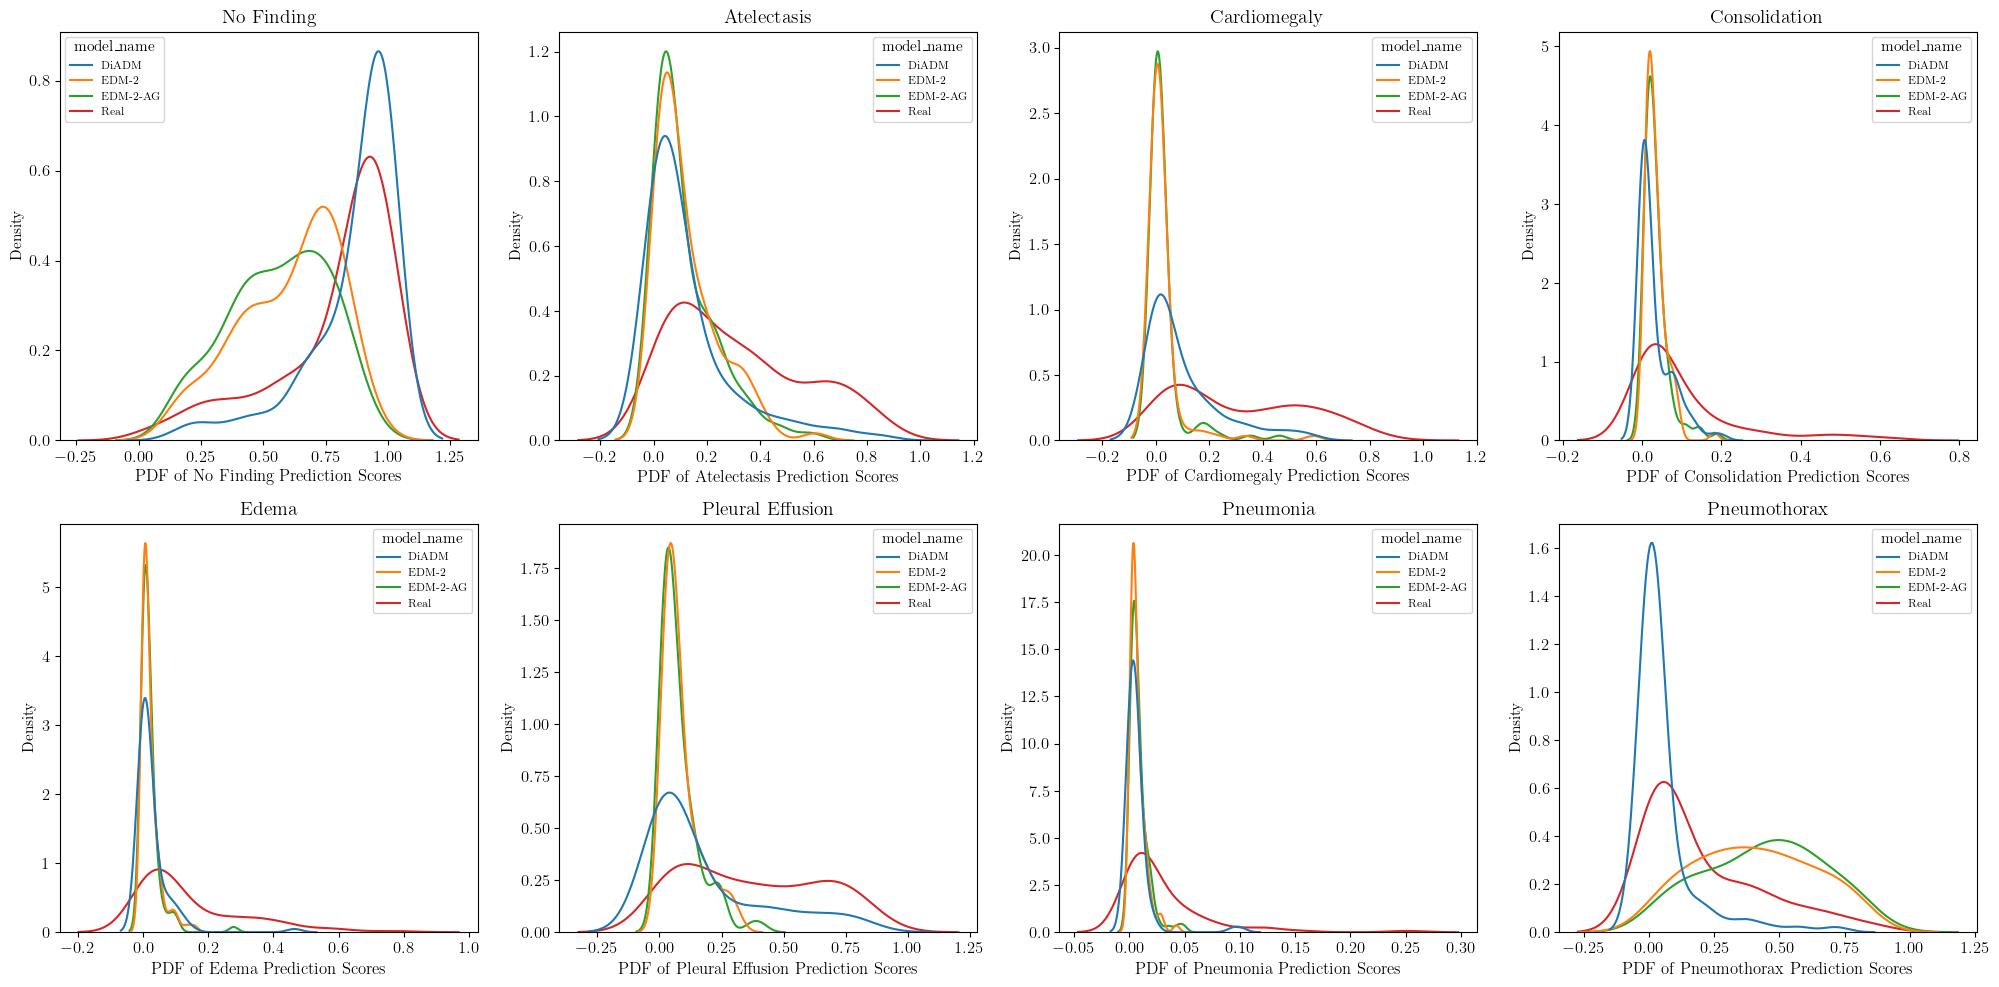

In [24]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Create a 2x4 grid for plotting
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through class labels and axes
for ax, class_label in zip(axes, class_labels):
    # Filter the DataFrame for the current class
    filtered_df = res_df[res_df["class_name"] == class_label]
    
    # Create a KDE plot for the filtered data
    sns.kdeplot(
        data=filtered_df,
        x=class_label, 
        hue="model_name", 
        ax=ax
    )
    ax.set_title(class_label, fontsize=14)  # Set the title for each subplot
    ax.set_xlabel(f"PDF of {class_label} Prediction Scores", fontsize=12)  # Rename x-axis
    ax.tick_params(axis='x', labelsize=12)  # Adjust x-axis label size
    ax.tick_params(axis='y', labelsize=12)  # Adjust y-axis label size

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("classifier_pred_scores.pdf", dpi=400)
plt.show()